<a href="https://colab.research.google.com/github/pakimmort/CodeAlpha_Machine-learning/blob/main/credit_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy.stats import chi2_contingency, f_oneway

# Machine Learning
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Configuration
SEED = 42
np.random.seed(SEED)

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6), 'figure.dpi': 100,
    'axes.spines.top': False, 'axes.spines.right': False
})

# Color Palette
COLORS = {'primary': '#2C3E50', 'secondary': '#3498DB', 'accent': '#E74C3C',
          'success': '#27AE60', 'warning': '#F39C12', 'info': '#9B59B6'}
CREDIT_PALETTE = [COLORS['success'], COLORS['warning'], COLORS['accent']]

print('✅ Environment configured!')

✅ Environment configured!


In [17]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

/tmp/ipython-input-1023157591.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train.csv')


In [21]:
print (train_data.shape)
test_data.shape

(100000, 28)


(50000, 27)

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [23]:
train_data.isnull().sum()

,0
ID,0
Customer_ID,0
Month,0
Name,9985
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


In [27]:
print(train_data["Credit_Score"].value_counts())
print(train_data["Credit_Score"].value_counts(normalize=True).round(3))

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64
Credit_Score
Standard    0.532
Poor        0.290
Good        0.178
Name: proportion, dtype: float64


In [25]:
missing = train_data.isna().mean().sort_values(ascending=False)
print(missing.head(15))

Monthly_Inhand_Salary      0.15002
Type_of_Loan               0.11408
Name                       0.09985
Credit_History_Age         0.09030
Num_of_Delayed_Payment     0.07002
Amount_invested_monthly    0.04479
Num_Credit_Inquiries       0.01965
Monthly_Balance            0.01200
Month                      0.00000
Age                        0.00000
Customer_ID                0.00000
ID                         0.00000
Interest_Rate              0.00000
Num_Credit_Card            0.00000
Num_Bank_Accounts          0.00000
dtype: float64


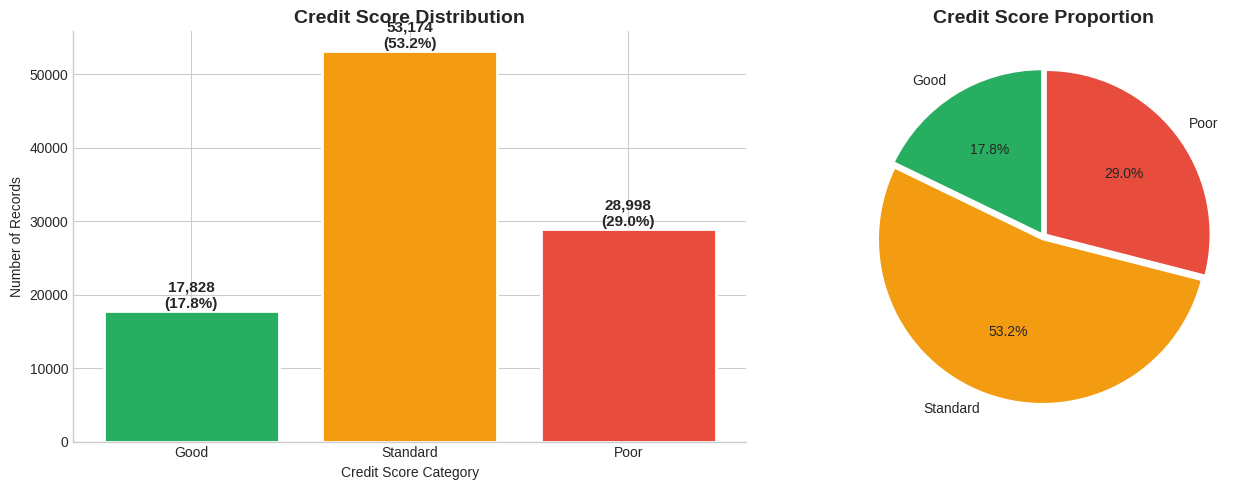


📊 Target Distribution:
   Good       → 17,828 (17.8%)
   Standard   → 53,174 (53.2%)
   Poor       → 28,998 (29.0%)


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

credit_order = ['Good', 'Standard', 'Poor']
credit_counts = train_data['Credit_Score'].value_counts()[credit_order]

# Bar Chart
bars = axes[0].bar(credit_order, credit_counts.values, color=CREDIT_PALETTE, edgecolor='white', linewidth=2)
axes[0].set_title('Credit Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Credit Score Category')
axes[0].set_ylabel('Number of Records')

for bar, count in zip(bars, credit_counts.values):
    axes[0].annotate(f'{count:,}\n({count/len(train_data)*100:.1f}%)',
                     xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie Chart
axes[1].pie(credit_counts.values, labels=credit_order, colors=CREDIT_PALETTE,
            autopct='%1.1f%%', explode=(0.02, 0.02, 0.02), startangle=90,
            wedgeprops={'edgecolor': 'white'})
axes[1].set_title('Credit Score Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n📊 Target Distribution:')
for cat, count in credit_counts.items():
    print(f'   {cat:10} → {count:>6,} ({count/len(train_data)*100:.1f}%)')

In [35]:
train_data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.17,3183.69,303.65,1625.57,3093.75,5957.45,15204.63
Num_Bank_Accounts,100000.0,17.09,117.40,-1.00,3.00,6.00,7.00,1798.00
Num_Credit_Card,100000.0,22.47,129.06,0.00,4.00,5.00,7.00,1499.00
Interest_Rate,100000.0,72.47,466.42,1.00,8.00,13.00,20.00,5797.00
Delay_from_due_date,100000.0,21.07,14.86,-5.00,10.00,18.00,28.00,67.00
Num_Credit_Inquiries,98035.0,27.75,193.18,0.00,3.00,6.00,9.00,2597.00
Credit_Utilization_Ratio,100000.0,32.29,5.12,20.00,28.05,32.31,36.50,50.00
Total_EMI_per_month,100000.0,1403.12,8306.04,0.00,30.31,69.25,161.22,82331.00


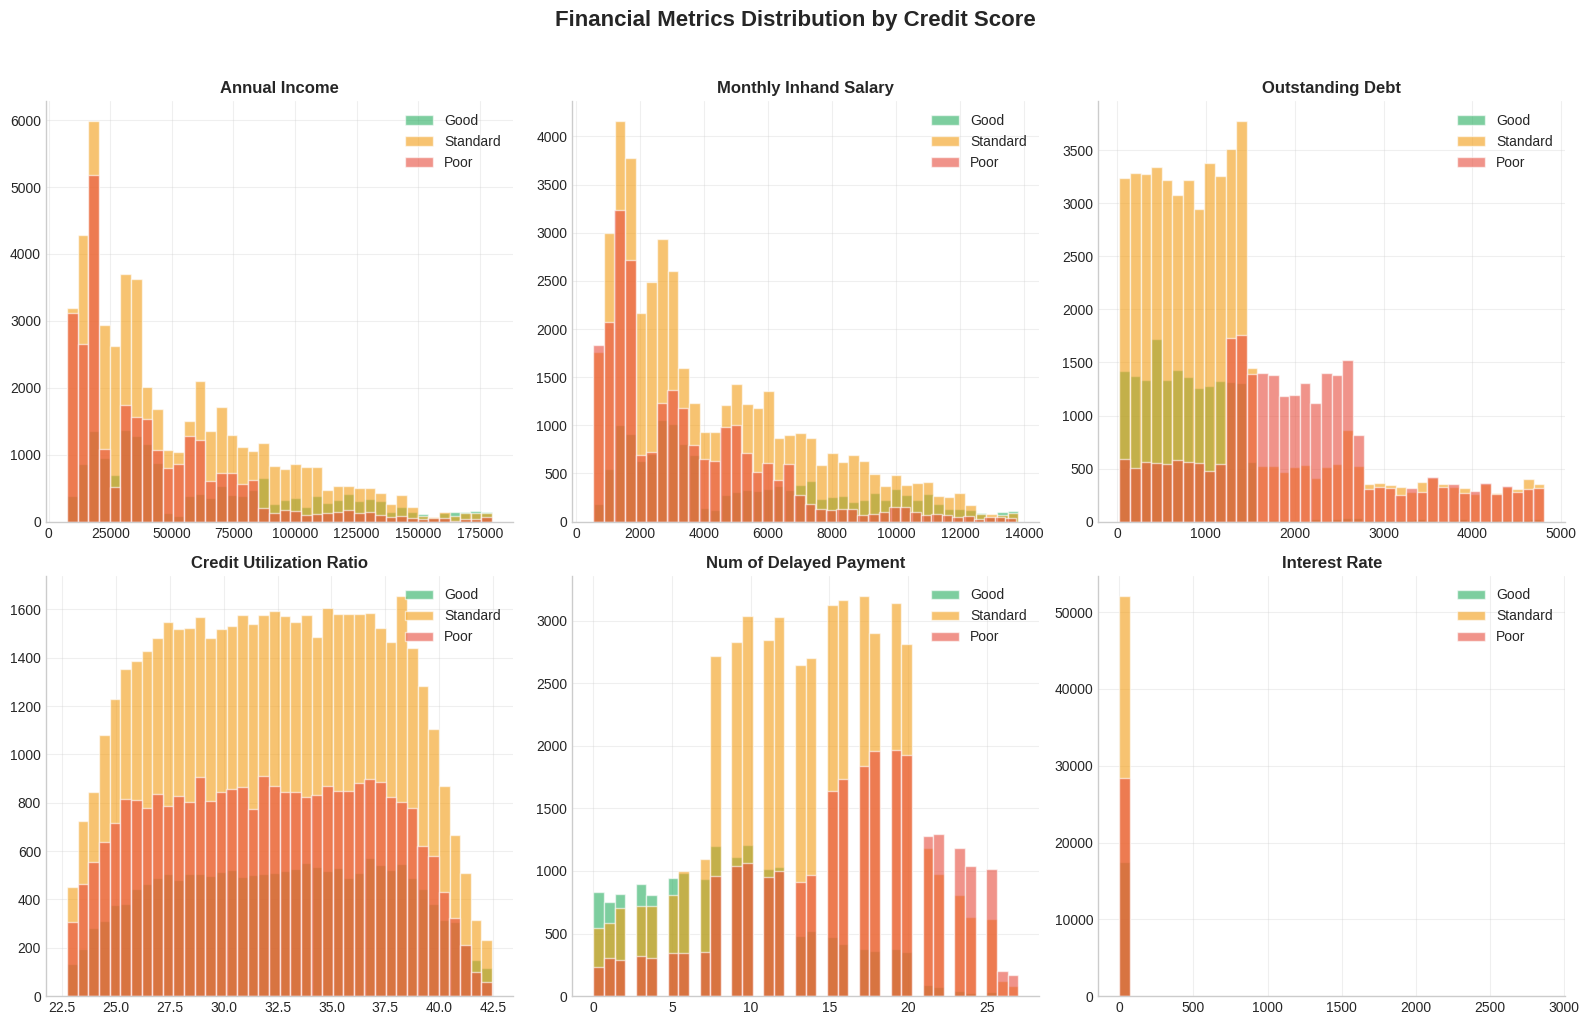

In [36]:
def clean_numeric_for_viz(series):
    s = series.copy()
    if s.dtype == 'object':
        s = s.str.replace(r'[^\d.-]', '', regex=True)
        s = pd.to_numeric(s, errors='coerce')
    return s

key_metrics = ['Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt',
               'Credit_Utilization_Ratio', 'Num_of_Delayed_Payment', 'Interest_Rate']

train_viz = train_data.copy()
for col in key_metrics:
    if col in train_viz.columns:
        train_viz[col] = clean_numeric_for_viz(train_viz[col])

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(key_metrics):
    data = train_viz[[col, 'Credit_Score']].dropna()
    q1, q3 = data[col].quantile([0.01, 0.99])
    data = data[(data[col] >= q1) & (data[col] <= q3)]

    for i, credit_type in enumerate(['Good', 'Standard', 'Poor']):
        subset = data[data['Credit_Score'] == credit_type][col]
        axes[idx].hist(subset, bins=40, alpha=0.6, label=credit_type,
                      color=CREDIT_PALETTE[i], edgecolor='white')

    axes[idx].set_title(col.replace('_', ' '), fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Financial Metrics Distribution by Credit Score', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


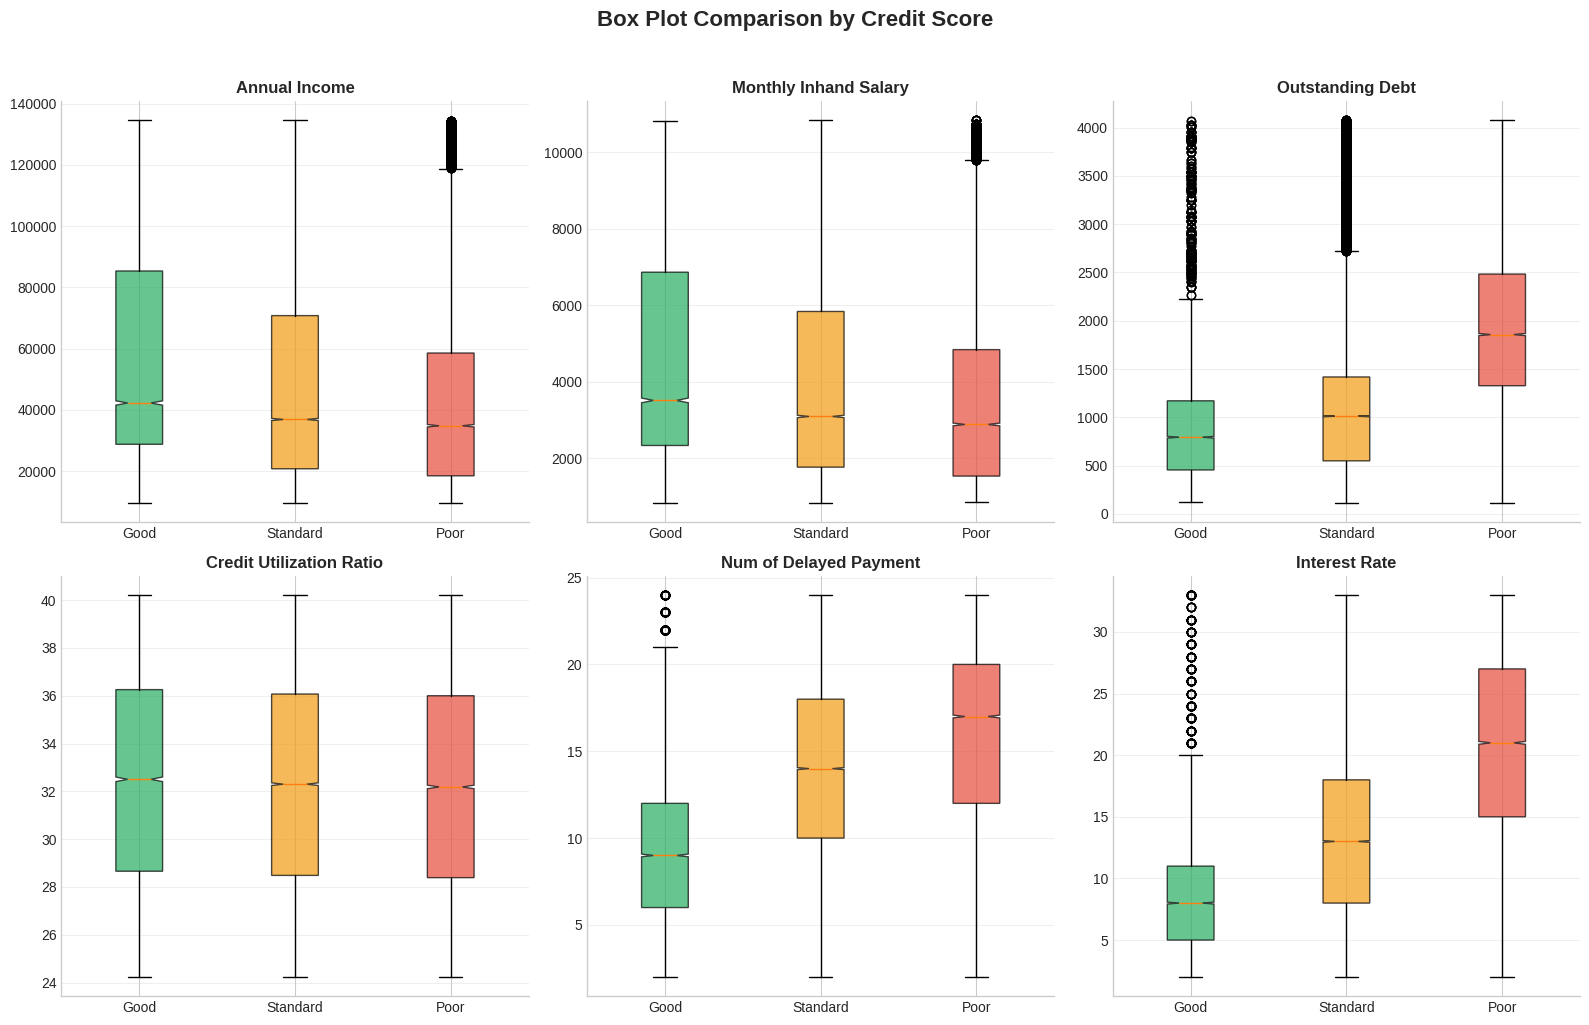

In [37]:
# Box Plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(key_metrics):
    data = train_viz[[col, 'Credit_Score']].dropna()
    q1, q3 = data[col].quantile([0.05, 0.95])
    data = data[(data[col] >= q1) & (data[col] <= q3)]

    box_data = [data[data['Credit_Score'] == cat][col].values for cat in ['Good', 'Standard', 'Poor']]
    bp = axes[idx].boxplot(box_data, labels=['Good', 'Standard', 'Poor'], patch_artist=True, notch=True)

    for patch, color in zip(bp['boxes'], CREDIT_PALETTE):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_title(col.replace('_', ' '), fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Box Plot Comparison by Credit Score', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

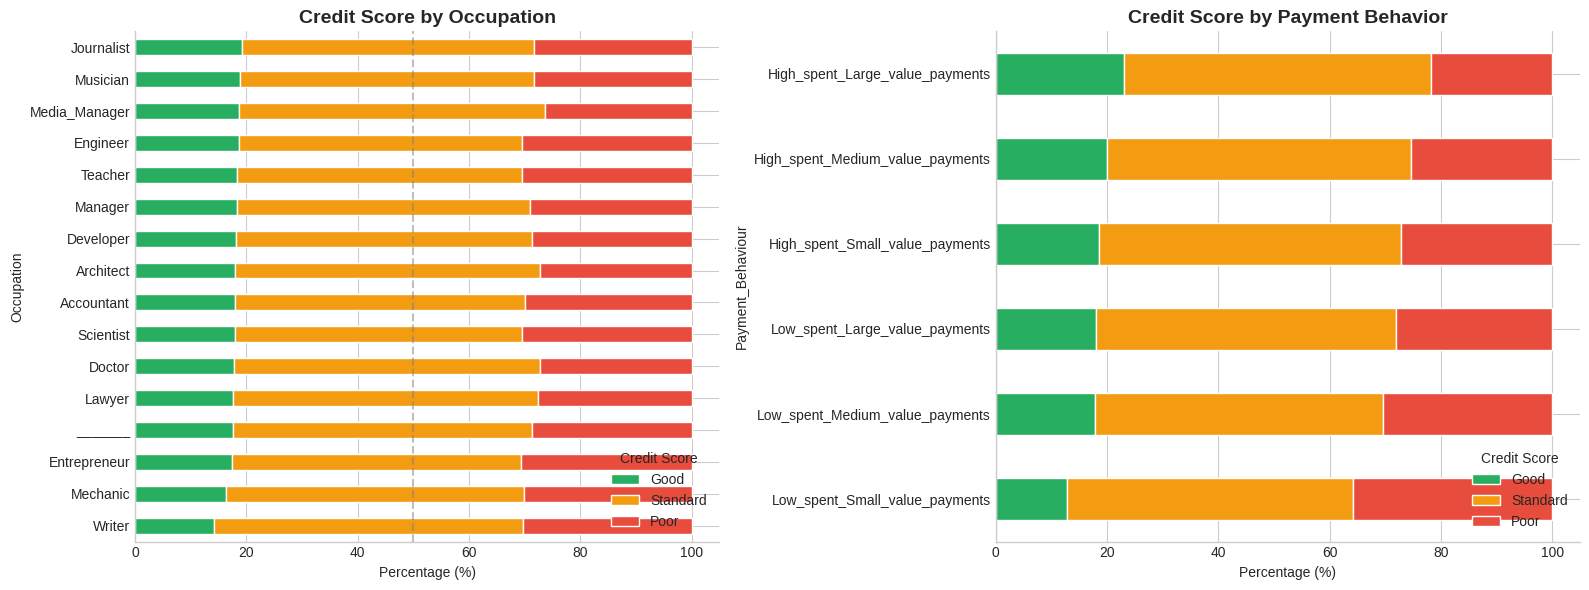

In [38]:
# Occupation & Payment Behavior
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Occupation
occ_credit = pd.crosstab(train_data['Occupation'], train_data['Credit_Score'], normalize='index') * 100
occ_credit = occ_credit[['Good', 'Standard', 'Poor']].sort_values('Good', ascending=True)
occ_credit.plot(kind='barh', stacked=True, ax=axes[0], color=CREDIT_PALETTE, edgecolor='white')
axes[0].set_title('Credit Score by Occupation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Percentage (%)')
axes[0].legend(title='Credit Score', loc='lower right')
axes[0].axvline(x=50, color='gray', linestyle='--', alpha=0.5)

# Payment Behavior
pb_clean = train_data['Payment_Behaviour'].replace({'!@9#%8': np.nan}).dropna()
pb_credit = pd.crosstab(pb_clean, train_data.loc[pb_clean.index, 'Credit_Score'], normalize='index') * 100
pb_credit = pb_credit[['Good', 'Standard', 'Poor']].sort_values('Good', ascending=True)
pb_credit.plot(kind='barh', stacked=True, ax=axes[1], color=CREDIT_PALETTE, edgecolor='white')
axes[1].set_title('Credit Score by Payment Behavior', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Percentage (%)')
axes[1].legend(title='Credit Score', loc='lower right')

plt.tight_layout()
plt.show()

In [41]:
# Missing Values Analysis
missing = train_data.isnull().sum()
missing_pct = (missing / len(train_data) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, '%': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('%', ascending=False)
print('📊 Missing Values:')
display(missing_df)

# Placeholder values
placeholders = ['_', 'NA', '!@9#%8', '-']
print('\n🔍 Placeholder Values:')
for col in train_data.select_dtypes(include='object').columns:
    count = train_data[col].isin(placeholders).sum()
    if count > 0:
        print(f'   {col:35} → {count:>6,} ({count/len(train_data)*100:.2f}%)')

📊 Missing Values:


,Missing,%
Monthly_Inhand_Salary,15002,15.00
Type_of_Loan,11408,11.41
Name,9985,9.98
Credit_History_Age,9030,9.03
Num_of_Delayed_Payment,7002,7.00
Amount_invested_monthly,4479,4.48
Num_Credit_Inquiries,1965,1.96
Monthly_Balance,1200,1.20



🔍 Placeholder Values:
   Changed_Credit_Limit                →  2,091 (2.09%)
   Credit_Mix                          → 20,195 (20.20%)
   Payment_Behaviour                   →  7,600 (7.60%)


In [42]:
# Data Cleaning Functions
def to_nan_placeholders(series):
    placeholders = ['_', 'NA', 'na', '', ' ', '!@9#%8', '-', 'NaN', 'nan', 'None']
    s = series.copy().replace(placeholders, np.nan)
    return s.replace(r'^\s*$', np.nan, regex=True)

def clean_numeric(series):
    s = to_nan_placeholders(series)
    if s.dtype == 'object':
        s = s.astype(str).str.replace(r'[^\d.-]', '', regex=True).replace('', np.nan)
    return pd.to_numeric(s, errors='coerce')

def credit_history_to_months(series):
    s = to_nan_placeholders(series)
    years = s.str.extract(r'(\d+)\s*Years?', expand=False).astype(float)
    months = s.str.extract(r'(\d+)\s*Months?', expand=False).astype(float)
    return (years.fillna(0) * 12 + months.fillna(0)).replace(0, np.nan)

def count_loan_types(series):
    s = to_nan_placeholders(series)
    def _count(x):
        if pd.isna(x): return np.nan
        parts = [p.strip() for p in str(x).replace(' and ', ', ').split(',') if p.strip()]
        return len(set(parts)) if parts else np.nan
    return s.apply(_count)

MONTH_MAP = {m: i+1 for i, m in enumerate(['January','February','March','April','May','June',
                                           'July','August','September','October','November','December'])}

def clean_dataset(df):
    df = df.copy()

    # Clean placeholders
    for col in df.select_dtypes(include='object').columns:
        df[col] = to_nan_placeholders(df[col])

    # Clean numeric columns
    numeric_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                    'Amount_invested_monthly', 'Monthly_Balance']

    for col in numeric_cols:
        if col in df.columns:
            df[col] = clean_numeric(df[col])

    # Age sanity check
    if 'Age' in df.columns:
        df.loc[(df['Age'] < 18) | (df['Age'] > 100), 'Age'] = np.nan

    # Feature transformations
    if 'Credit_History_Age' in df.columns:
        df['Credit_History_Months'] = credit_history_to_months(df['Credit_History_Age'])
        df.drop(columns=['Credit_History_Age'], inplace=True)

    if 'Month' in df.columns:
        df['Month_Num'] = df['Month'].map(MONTH_MAP)
        df.drop(columns=['Month'], inplace=True)

    if 'Type_of_Loan' in df.columns:
        df['Num_Loan_Types'] = count_loan_types(df['Type_of_Loan'])
        df.drop(columns=['Type_of_Loan'], inplace=True)

    return df

print('✅ Cleaning functions defined!')

✅ Cleaning functions defined!


In [44]:
train_clean = clean_dataset(train_data)
test_clean = clean_dataset(test_data)

print(f'✅ Cleaned Train: {train_clean.shape}')
print(f'✅ Cleaned Test: {test_clean.shape}')
train_clean.head(3)


✅ Cleaned Train: (100000, 28)
✅ Cleaned Test: (50000, 27)


,ID,Customer_ID,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Months,Month_Num,Num_Loan_Types
0,0x1602,CUS_0xd40,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,4,...,26.822620,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,265.0,1,4.0
1,0x1603,CUS_0xd40,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,NaN,3,4,...,31.944960,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good,NaN,2,4.0
2,0x1604,CUS_0xd40,Aaron Maashoh,NaN,821-00-0265,Scientist,19114.12,NaN,3,4,...,28.609352,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good,267.0,3,4.0


In [45]:
def safe_divide(a, b, fill=0):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = a / b
        result = np.where(np.isinf(result) | np.isnan(result), fill, result)
    return result

def engineer_features(df):
    df = df.copy()

    # Financial Ratios
    df['Debt_to_Income'] = safe_divide(df['Outstanding_Debt'], df['Annual_Income'])
    df['Savings_Rate'] = safe_divide(df['Amount_invested_monthly'], df['Monthly_Inhand_Salary'])
    df['EMI_Burden'] = safe_divide(df['Total_EMI_per_month'], df['Monthly_Inhand_Salary'])
    df['Balance_to_Salary'] = safe_divide(df['Monthly_Balance'], df['Monthly_Inhand_Salary'])

    # Credit Behavior
    df['Delay_Severity'] = df['Delay_from_due_date'].fillna(0) * df['Num_of_Delayed_Payment'].fillna(0)
    df['Cards_per_Account'] = safe_divide(df['Num_Credit_Card'], df['Num_Bank_Accounts'])
    df['Inquiry_per_Card'] = safe_divide(df['Num_Credit_Inquiries'], df['Num_Credit_Card'])

    # Risk Indicators
    df['High_Utilization'] = (df['Credit_Utilization_Ratio'] > 70).astype(int)
    df['Has_Delayed_Payments'] = (df['Num_of_Delayed_Payment'].fillna(0) > 0).astype(int)
    df['Multiple_Loans'] = (df['Num_of_Loan'].fillna(0) > 3).astype(int)
    df['High_Interest'] = (df['Interest_Rate'].fillna(0) > 15).astype(int)

    # Credit History Ratio
    df['Credit_History_to_Age'] = safe_divide(df['Credit_History_Months'], df['Age'] * 12)

    # Cap extreme values
    for col in df.select_dtypes(include=[np.number]).columns:
        q01, q99 = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lower=q01, upper=q99)

    df = df.replace([np.inf, -np.inf], np.nan)
    return df

train_fe = engineer_features(train_clean)
test_fe = engineer_features(test_clean)

print(f'✅ Feature Engineering Complete!')
print(f'📊 Features: {train_fe.shape[1]} (added {train_fe.shape[1] - train_clean.shape[1]} new)')

✅ Feature Engineering Complete!
📊 Features: 40 (added 12 new)


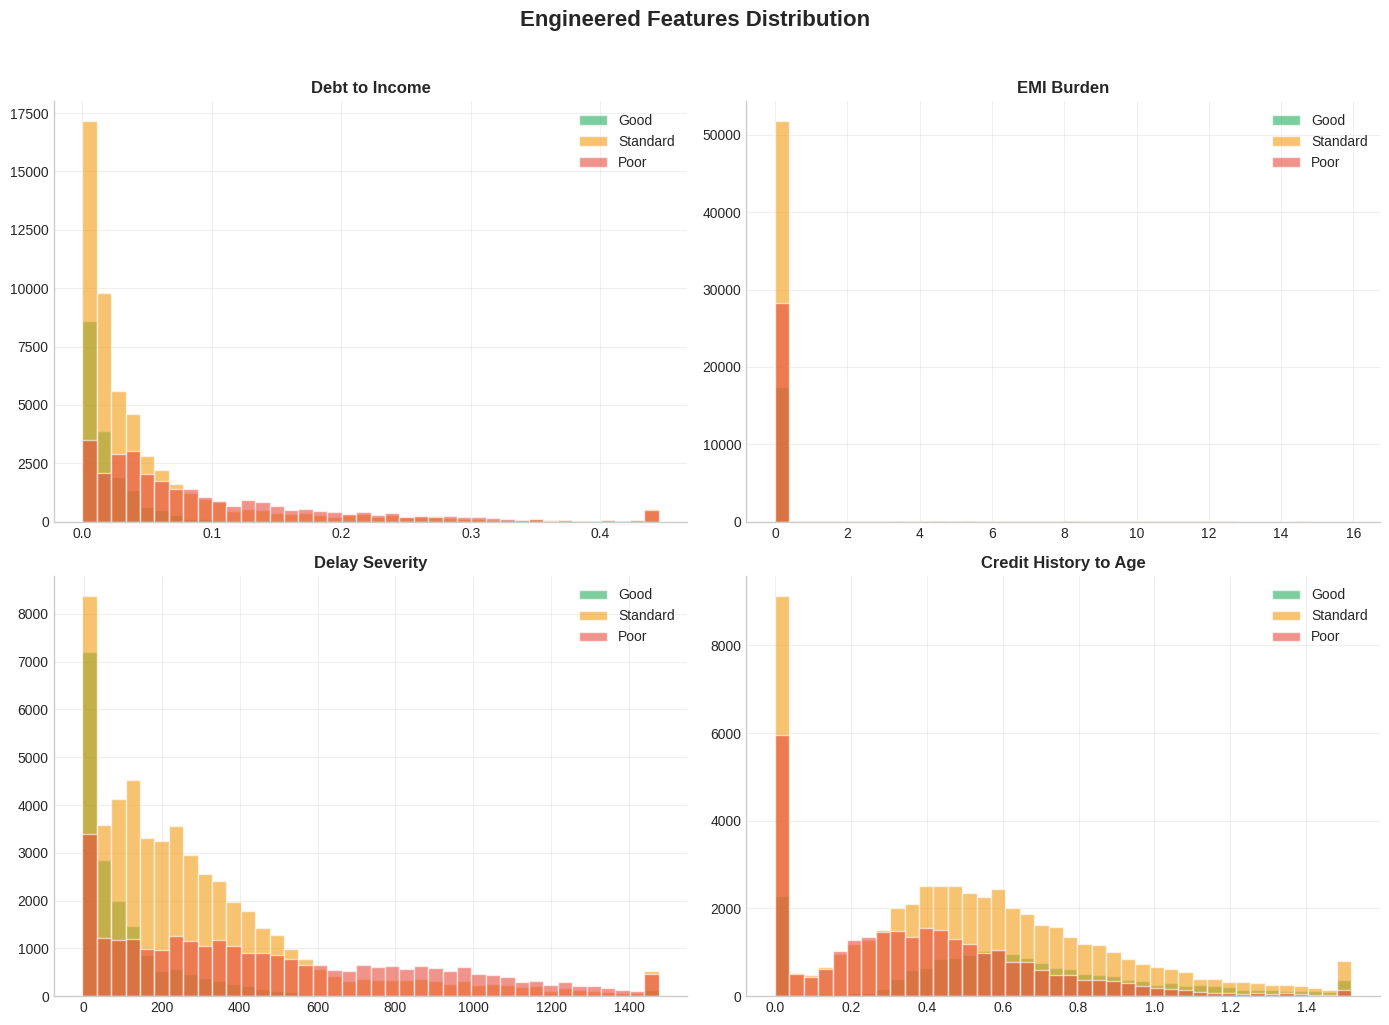

In [46]:
# Visualize Engineered Features
new_features = ['Debt_to_Income', 'EMI_Burden', 'Delay_Severity', 'Credit_History_to_Age']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(new_features):
    data = train_fe[[col, 'Credit_Score']].dropna()
    q99 = data[col].quantile(0.99)
    data = data[data[col] <= q99]

    for i, credit_type in enumerate(['Good', 'Standard', 'Poor']):
        subset = data[data['Credit_Score'] == credit_type][col]
        axes[idx].hist(subset, bins=40, alpha=0.6, label=credit_type,
                      color=CREDIT_PALETTE[i], edgecolor='white')

    axes[idx].set_title(col.replace('_', ' '), fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Engineered Features Distribution', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

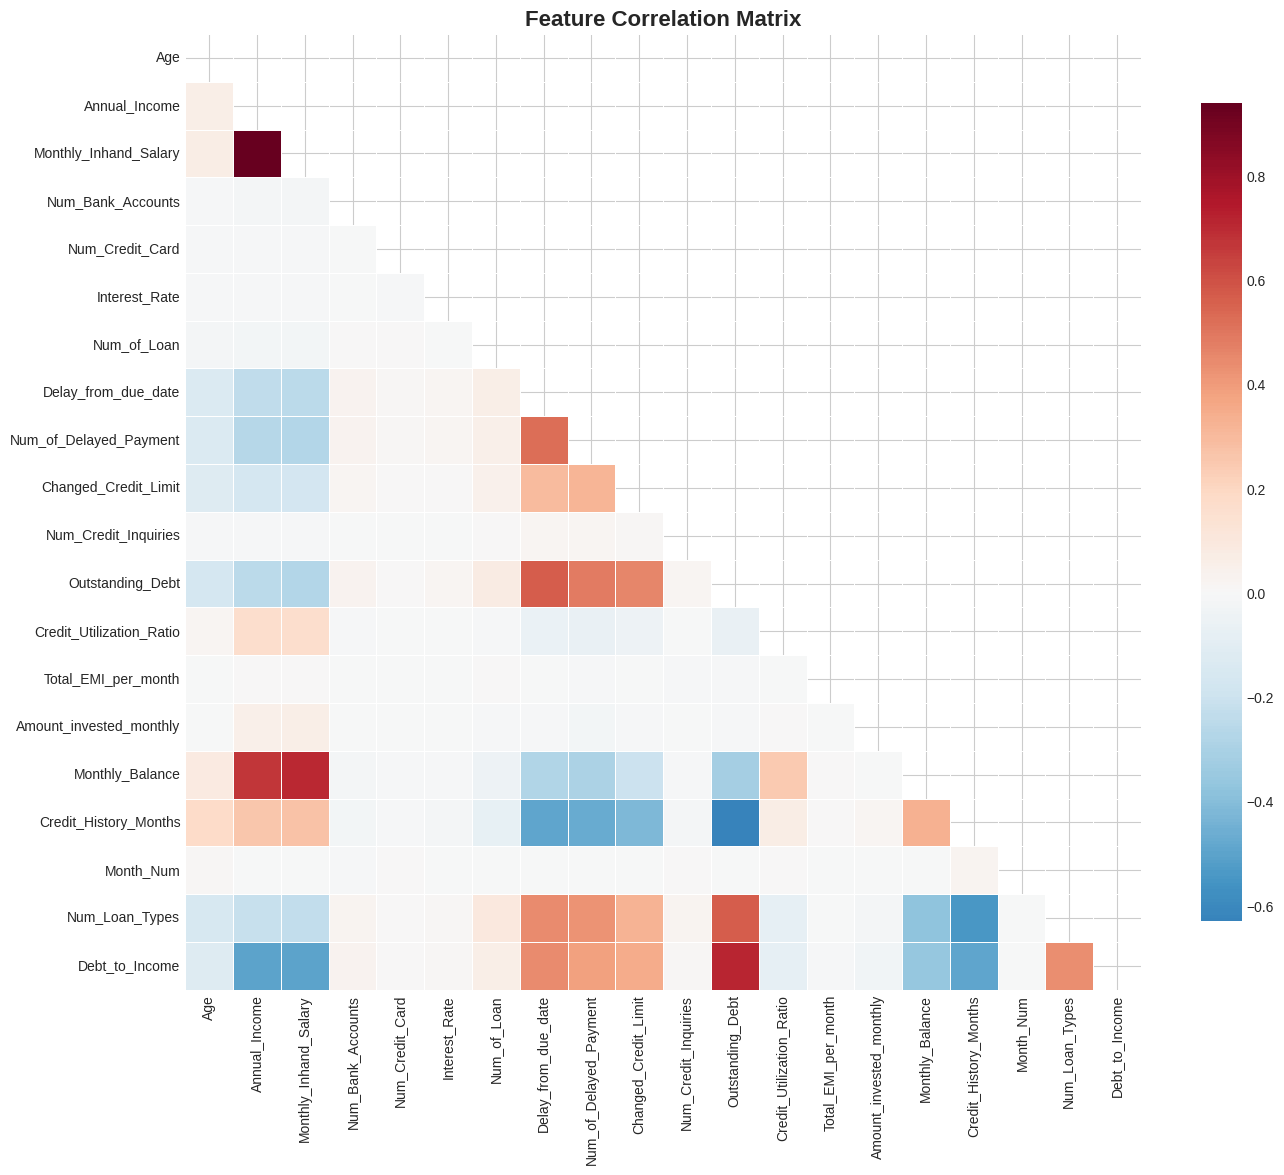

In [47]:
# Correlation Matrix
numeric_cols = train_fe.select_dtypes(include=[np.number]).columns[:20]
corr_matrix = train_fe[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [48]:
# ANOVA Tests
print('📊 ANOVA Tests (Numerical Features)')
print('='*60)

test_features = ['Annual_Income', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
                 'Num_of_Delayed_Payment', 'Debt_to_Income', 'Credit_History_Months']

results = []
for feature in test_features:
    if feature in train_fe.columns:
        data = train_fe[[feature, 'Credit_Score']].dropna()
        groups = [data[data['Credit_Score'] == cat][feature].values for cat in ['Good', 'Standard', 'Poor']]
        f_stat, p_value = f_oneway(*groups)
        results.append({'Feature': feature, 'F-Statistic': f_stat, 'P-Value': p_value,
                       'Significant': '✓' if p_value < 0.05 else ''})

pd.DataFrame(results)

📊 ANOVA Tests (Numerical Features)


,Feature,F-Statistic,P-Value,Significant
0,Annual_Income,2132.426061,0.000000e+00,✓
1,Outstanding_Debt,9146.245005,0.000000e+00,✓
2,Credit_Utilization_Ratio,100.675475,2.094870e-44,✓
3,Num_of_Delayed_Payment,7744.194265,0.000000e+00,✓
4,Debt_to_Income,5541.638599,0.000000e+00,✓
5,Credit_History_Months,8136.164749,0.000000e+00,✓


In [50]:
# Prepare Data
DROP_COLS = ['ID', 'Customer_ID', 'Name', 'SSN', 'Credit_Score']
TARGET = 'Credit_Score'
GROUP_COL = 'Customer_ID'

X = train_fe.drop(columns=[c for c in DROP_COLS if c in train_fe.columns])
y = train_fe[TARGET]
groups = train_fe[GROUP_COL]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'📊 Features: {len(numeric_features)} numeric, {len(categorical_features)} categorical')

# Group-aware split (prevents data leakage)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(gss.split(X, y, groups))

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

print(f'📊 Train: {len(X_train):,} | Val: {len(X_val):,}')
print(f'📌 Customer Overlap: {len(set(groups.iloc[train_idx]) & set(groups.iloc[val_idx]))} (should be 0)')

📊 Features: 31 numeric, 4 categorical
📊 Train: 80,000 | Val: 20,000
📌 Customer Overlap: 0 (should be 0)


In [51]:
# Preprocessing Pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# Models to Compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=SEED, class_weight='balanced'),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, max_depth=10, random_state=SEED)
}

print(f'📊 Models: {list(models.keys())}')


📊 Models: ['Logistic Regression', 'Random Forest', 'Hist Gradient Boosting']


In [52]:
# Train & Evaluate Models
results = []
trained_models = {}

print('🚀 Training Models...')
print('='*70)

for name, model in models.items():
    print(f'\n📈 {name}...')

    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_weighted = f1_score(y_val, y_pred, average='weighted')

    results.append({'Model': name, 'Accuracy': acc, 'F1 (Macro)': f1_macro, 'F1 (Weighted)': f1_weighted})
    trained_models[name] = pipeline

    print(f'   Accuracy: {acc:.4f} | F1 Macro: {f1_macro:.4f} | F1 Weighted: {f1_weighted:.4f}')

results_df = pd.DataFrame(results).sort_values('F1 (Macro)', ascending=False)
print('\n📊 Results Summary:')
display(results_df)

🚀 Training Models...

📈 Logistic Regression...
   Accuracy: 0.6335 | F1 Macro: 0.6319 | F1 Weighted: 0.6347

📈 Random Forest...
   Accuracy: 0.6836 | F1 Macro: 0.6794 | F1 Weighted: 0.6854

📈 Hist Gradient Boosting...
   Accuracy: 0.7063 | F1 Macro: 0.6854 | F1 Weighted: 0.7065

📊 Results Summary:


,Model,Accuracy,F1 (Macro),F1 (Weighted)
2,Hist Gradient Boosting,0.70625,0.685403,0.706486
1,Random Forest,0.68365,0.679371,0.685370
0,Logistic Regression,0.63350,0.631858,0.634650


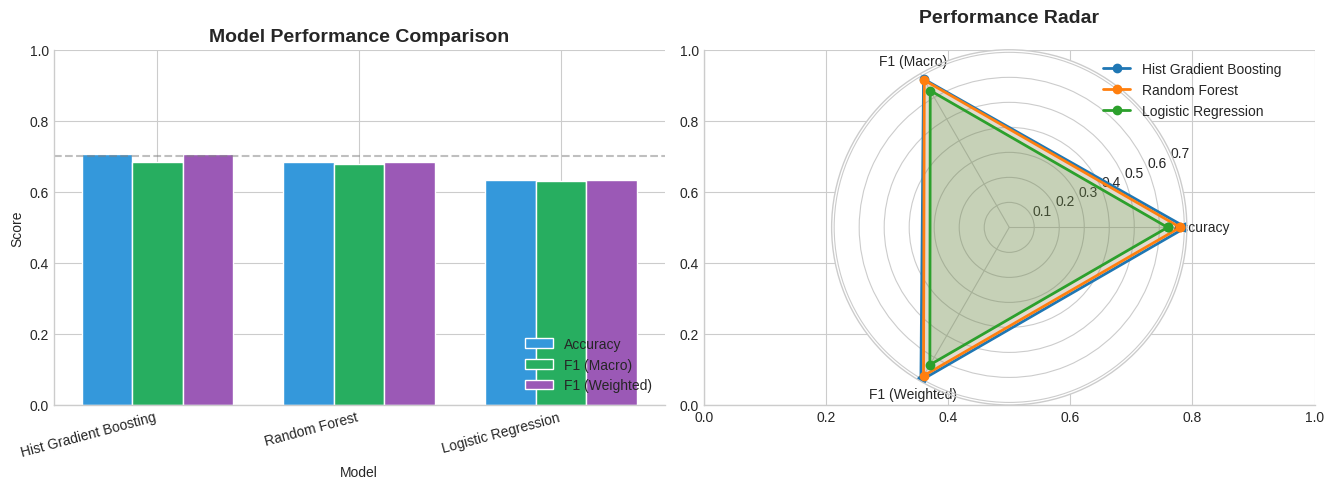

In [53]:
# Model Comparison Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar Chart
x = np.arange(len(results_df))
width = 0.25
metrics = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)']
colors_bar = [COLORS['secondary'], COLORS['success'], COLORS['info']]

for i, (metric, color) in enumerate(zip(metrics, colors_bar)):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric, color=color, edgecolor='white')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)

# Radar Chart
from math import pi
categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax_radar = plt.subplot(1, 2, 2, projection='polar')
for idx, row in results_df.iterrows():
    values = [row['Accuracy'], row['F1 (Macro)'], row['F1 (Weighted)']]
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    ax_radar.fill(angles, values, alpha=0.15)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories)
ax_radar.set_title('Performance Radar', fontsize=14, fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

In [54]:
# Best Model Analysis
best_name = results_df.iloc[0]['Model']
best_model = trained_models[best_name]
y_pred_best = best_model.predict(X_val)

print(f'🏆 Best Model: {best_name}')
print('='*60)
print(classification_report(y_val, y_pred_best, digits=4))

🏆 Best Model: Hist Gradient Boosting
              precision    recall  f1-score   support

        Good     0.5996    0.6264    0.6127      3694
        Poor     0.7207    0.6835    0.7016      5726
    Standard     0.7373    0.7464    0.7419     10580

    accuracy                         0.7063     20000
   macro avg     0.6859    0.6855    0.6854     20000
weighted avg     0.7071    0.7063    0.7065     20000



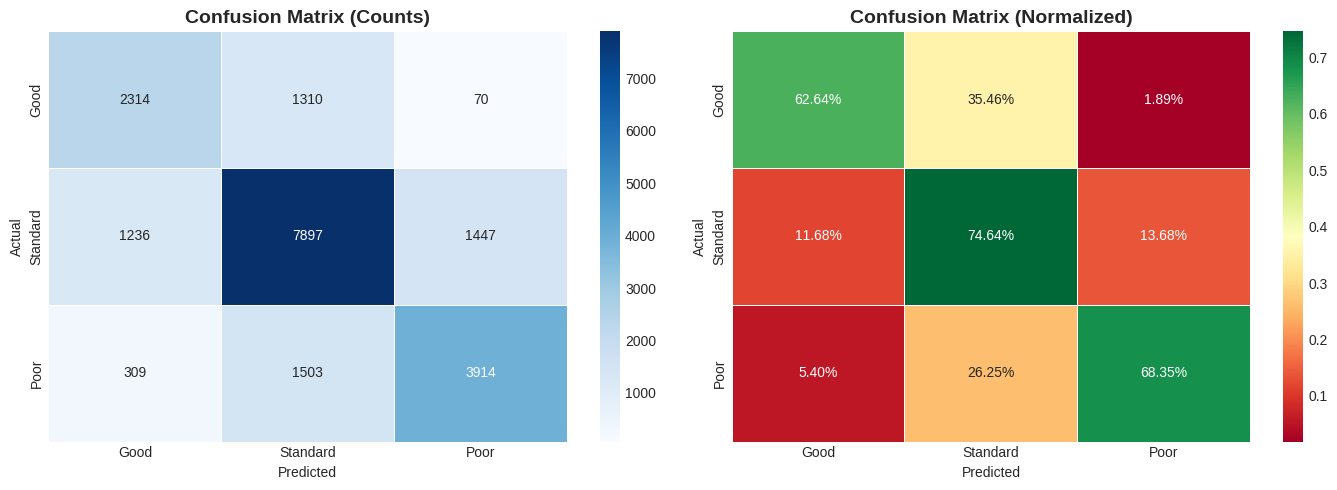


📊 Class Performance:
   Good       Recall: 62.64%
   Standard   Recall: 74.64%
   Poor       Recall: 68.35%


In [55]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = ['Good', 'Standard', 'Poor']
cm = confusion_matrix(y_val, y_pred_best, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=labels, yticklabels=labels, linewidths=0.5)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=labels, yticklabels=labels, linewidths=0.5)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print('\n📊 Class Performance:')
for i, label in enumerate(labels):
    print(f'   {label:10} Recall: {cm_norm[i, i]:.2%}')

In [56]:
# Feature Importance
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_names = (numeric_features +
                     list(best_model.named_steps['preprocessor']
                          .named_transformers_['cat']
                          .named_steps['encoder']
                          .get_feature_names_out(categorical_features)))

    importances = best_model.named_steps['classifier'].feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    imp_df = imp_df.sort_values('Importance', ascending=False)

    fig, ax = plt.subplots(figsize=(12, 8))
    top_n = 20
    colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))[::-1]

    ax.barh(range(top_n), imp_df['Importance'].head(top_n).values[::-1],
            color=colors_imp, edgecolor='white')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(imp_df['Feature'].head(top_n).values[::-1])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top {top_n} Features ({best_name})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    print('\n📊 Top 10 Features:')
    display(imp_df.head(10))

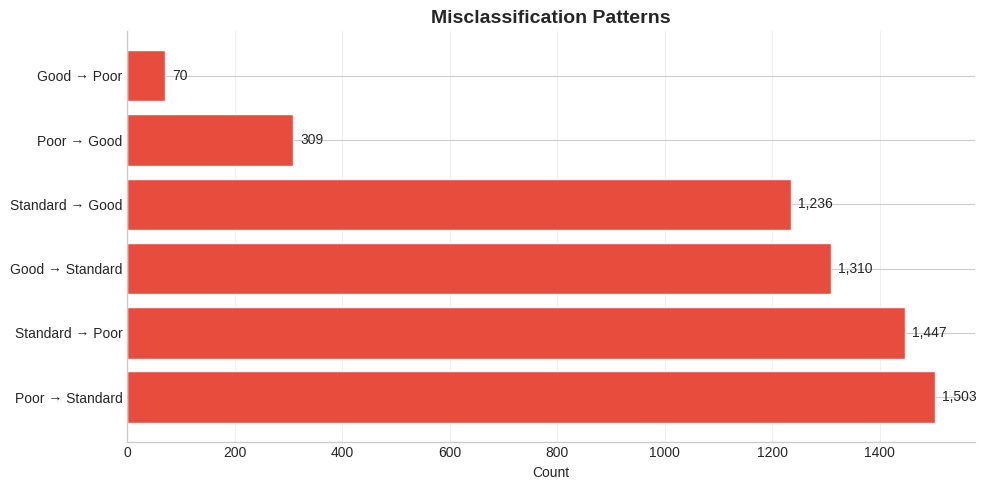


📊 Error Summary:


,Actual,Predicted,Count,Pattern
3,Poor,Standard,1503,Poor → Standard
5,Standard,Poor,1447,Standard → Poor
1,Good,Standard,1310,Good → Standard
4,Standard,Good,1236,Standard → Good
2,Poor,Good,309,Poor → Good
0,Good,Poor,70,Good → Poor


In [57]:
# Error Analysis
val_results = pd.DataFrame({'Actual': y_val.values, 'Predicted': y_pred_best})
val_results['Correct'] = val_results['Actual'] == val_results['Predicted']

error_df = val_results[~val_results['Correct']].groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
error_df = error_df.sort_values('Count', ascending=False)
error_df['Pattern'] = error_df['Actual'] + ' → ' + error_df['Predicted']

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(error_df['Pattern'], error_df['Count'], color=COLORS['accent'], edgecolor='white')
ax.set_xlabel('Count')
ax.set_title('Misclassification Patterns', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (_, row) in enumerate(error_df.iterrows()):
    ax.annotate(f'{row["Count"]:,}', xy=(row['Count'], i), ha='left', va='center',
                xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

print('\n📊 Error Summary:')
display(error_df)

In [59]:
# Generate Test Predictions
X_test = test_fe.drop(columns=[c for c in DROP_COLS if c in test_fe.columns])
predictions = best_model.predict(X_test)

submission = pd.DataFrame({'ID': test_data['ID'], 'Credit_Score': predictions})
submission.to_csv('credit_score_predictions.csv', index=False)

print('✅ Predictions saved!')
print(f'\n📊 Prediction Distribution:')
print(submission['Credit_Score'].value_counts())

✅ Predictions saved!

📊 Prediction Distribution:
Credit_Score
Standard    27257
Poor        13483
Good         9260
Name: count, dtype: int64
